# Install Packages and import libraries

In [ ]:
# install spacy
!python -m spacy download en_core_web_lg

2023-11-01 17:53:47.651842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 17:53:47.651893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 17:53:47.651917: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 17:53:47.657539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 17:53:48.566241: W tensorflow/compiler/

In [ ]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=a3e9d398ff819be1a7ad337227ccf8d755b655dd191d1bd5475bd48a0f48a8fc
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
# for data manipulation
import pandas as pd
import numpy as np
import os

# for scoring
import spacy
from collections import Counter

# for statistical analysis
import pingouin as pg
from scipy.stats import shapiro, levene, permutation_test
from statsmodels.stats.multitest import multipletests

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for analysis

Load your dataset: "hcV3-stories.csv"

In [ ]:
df=pd.read_csv('/content/hcV3-stories.csv', sep=';', encoding = "UTF-8")
df.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,mostSurprising,openness,recAgnPairId,recImgPairId,similarity,similarityReason,story,stressful,summary,timeSinceEvent
0,32RIADZISTQWI5XIVG5BN0VMYFRS4U,1641,E9TY34YY,25.0,man,white,1.0,1.0,NaN,3.0,...,when I got concert tickets,0.00,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,3.0,"I've been to a couple concerts, but not many.","Concerts are my most favorite thing, and my bo...",1.0,My boyfriend and I went to a concert together ...,90.0
1,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,1245,237K2NI1,25.0,woman,white,1.0,1.0,3.0,4.0,...,we saw the beautiful sky.,1.00,NaN,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,NaN,NaN,"The day started perfectly, with a great drive ...",1.0,My boyfriend and I went to a concert together ...,90.0
2,3IRIK4HM3B6UQBC0HI8Q5TBJZLEC61,1159,FK5QTANB,35.0,woman,black,1.0,1.0,NaN,4.0,...,she went into labor early,0.50,NaN,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,3.0,I am a mother myself,It seems just like yesterday but today makes f...,1.0,My sister gave birth to my twin niece and neph...,150.0
3,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,500,UYOSBBRS,30.0,woman,white,1.0,4.0,3.0,5.0,...,finding out they were healthy.,1.00,NaN,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,NaN,NaN,"Five months ago, my niece and nephew were born...",2.0,My sister gave birth to my twin niece and neph...,150.0
4,3MTMREQS4W44RBU8OMP3XSK8NMJAWZ,1074,34BFLNJV,25.0,man,white,2.0,2.0,NaN,3.0,...,When I don't answer the phone in case I owe th...,0.25,NaN,3018Q3ZVOJCZJFDMPSFXATCQG06AR3,4.0,Because I also have money problems,About a month ago I went to burning man. I was...,4.0,It is always a journey for me to go to burning...,30.0


In [ ]:
df.shape

(6854, 23)

In [ ]:
# remove retold stories
df = df[df['memType']!='retold']

In [ ]:
df.shape

(5535, 23)

In [ ]:
df.isna().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           17
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency            2756
importance            144
logTimeSinceEvent       0
mainEvent               0
memType                 1
mostSurprising          1
openness                2
recAgnPairId         4226
recImgPairId          209
similarity           2781
similarityReason     2781
story                  10
stressful             295
summary               295
timeSinceEvent        304
dtype: int64

In [ ]:
# story and memType contain missing values
df = df.dropna(subset=['story', 'memType'])

In [ ]:
df.shape

(5525, 23)

In [ ]:
print(f"Number of True statements: {df[df['memType'] == 'recalled'].shape[0]}")
print(f"Number of False statements: {df[df['memType'] == 'imagined'].shape[0]}")

Number of True statements: 2779
Number of False statements: 2746


# Text Preprocessing

**Preprocessing steps:**

Compute tokenization and remove punctuations and extra spaces to count the exact number of words.

In [ ]:
# Load Spacy's English language model
nlp = spacy.load("en_core_web_lg")

In [ ]:
docs = []

for doc in nlp.pipe(df['story'], n_process=os.cpu_count()-1, disable = ['transformer']):
    docs.append(doc)

In [ ]:
# Define a function to tokenize text
def tokenize(doc):

    # Remove punctuation and double space:
    tokens = [token.text for token in doc if not (token.is_punct or token.is_space)]
    # Join tokens back into a string
    tokens = " ".join(tokens)
    return tokens.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
tokens = []

for doc in docs:
    tokens.append(tokenize(doc))

# Add the preprocessed text as a new column in the dataframe
df['tokens'] = tokens

In [ ]:
df['tokens'][0]

"concerts are my most favorite thing and my boyfriend knew it that 's why for our anniversary he got me tickets to see my favorite artist not only that but the tickets were for an outdoor show which i love much more than being in a crowded stadium since he knew i was such a big fan of music he got tickets for himself and even a couple of my friends he is so incredibly nice and considerate to me and what i like to do i will always remember this event and i will always cherish him on the day of the concert i got ready and he picked me up and we went out to a restaurant beforehand he is so incredibly romantic he knew exactly where to take me without asking we ate laughed and had a wonderful dinner date before the big event we arrived at the concert and the music was so incredibly beautiful i loved every minute of it my friends boyfriend and i all sat down next to each other as the music was slowly dying down i found us all getting lost just staring at the stars it was such an incredibly u

In [ ]:
# Define a function to lemmatize content words
def preprocessed_text(doc):
    # Remove punctuation, double space, stop words and lemmatize text:
    clean_tokens = [token.lemma_ for token in doc if not (token.is_punct or token.is_space or token.is_stop)]
    # Join the cleaned tokens back into a string
    clean_text = " ".join(clean_tokens)
    return clean_text.lower()

In [ ]:
# Apply the preprocessing pipeline using nlp.pipe
clean_text = []

for doc in docs:
    clean_text.append(preprocessed_text(doc))

# Add the preprocessed text as a new column in the dataframe
df['clean_text'] = clean_text

In [ ]:
df['clean_text'][0]

'concert favorite thing boyfriend know anniversary get ticket favorite artist ticket outdoor love crowded stadium know big fan music get ticket couple friend incredibly nice considerate like remember event cherish day concert get ready pick go restaurant incredibly romantic know exactly ask eat laugh wonderful dinner date big event arrive concert music incredibly beautiful love minute friend boyfriend sit music slowly die find getting lose stare star incredibly unforgettable beautiful night'

In [ ]:
# Number of words per story:
word_counts = [len(text.split()) for text in df['tokens']]
df['word_counts'] = word_counts

In [ ]:
# Write a function to compute the statistics of number of words in a text.
# word_counts_vec should be a vector with the total number of tokens for each text.

def num_of_words_stat(word_counts_vec):

  # Split each story into words and count the number of words

  # Find the minimum and maximum number of words
  min_words = word_counts_vec.min()
  max_words = word_counts_vec.max()
  mean_words = word_counts_vec.mean()
  std_words = word_counts_vec.std()

  print(f"Minimum number of words: {min_words}")
  print(f"Maximum number of words: {max_words}")
  print(f"Average number of words: {mean_words}")
  print(f"Standard deviation number of words: {std_words}")

  return min_words, max_words, mean_words, std_words

In [ ]:
# Compute the minimum, maximum, average and std number of word for all the stories
print('All stories in Hippocorpus')
print()
min, max, avg, std = num_of_words_stat(df['word_counts'])

All stories in Hippocorpus

Minimum number of words: 2
Maximum number of words: 625
Average number of words: 254.39656108597285
Standard deviation number of words: 93.3016160216731


In [ ]:
# split real and imagined stories
df_h=df[df['memType']=='recalled']
df_d=df[df['memType']=='imagined']

In [ ]:
# Compute the minimum, maximum, average and std number of word for RECALLED the stories
print('Recalled Stories')
print()
min_rec, max_rec, avg_rec, std_rec = num_of_words_stat(df_h['word_counts'])

Recalled Stories

Minimum number of words: 2
Maximum number of words: 625
Average number of words: 268.9409859661749
Standard deviation number of words: 95.13282049602334


In [ ]:
# Compute the minimum, maximum, average and std number of word for IMAGINED the stories
print('Imagined stories')
print()
min_img, max_img, avg_img, std_img = num_of_words_stat(df_d['word_counts'])

Imagined stories

Minimum number of words: 6
Maximum number of words: 609
Average number of words: 239.6773488710852
Standard deviation number of words: 89.04076578318917


Here we have that the minim number of words seems too low (i.e., 2). Explore the stories with the minimum number of words:

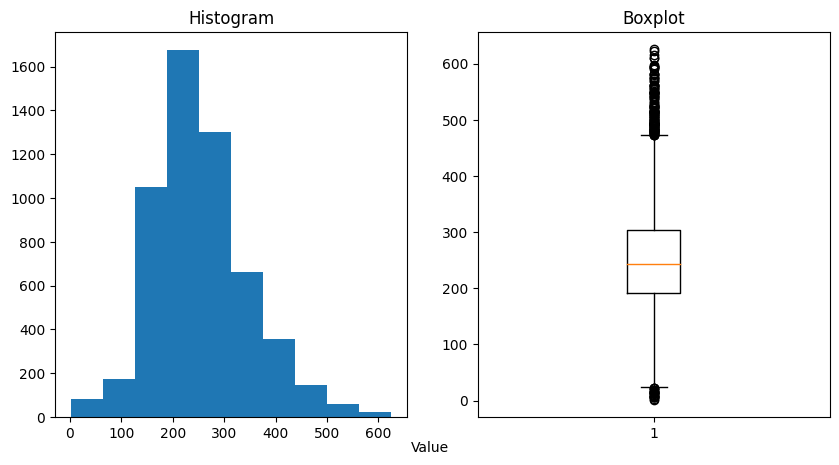

In [ ]:
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the histogram on the first axis
ax1.hist(df['word_counts'], bins=10)
ax1.set_title('Histogram')

# plot the boxplot on the second axis
ax2.boxplot(df['word_counts'])
ax2.set_title('Boxplot')

# add a common x-axis label
fig.text(0.5, 0.04, 'Value', ha='center')

# show the plot
plt.show()


In [ ]:
# Let's check the stories that have a number of words below 2.5 std
df[df['word_counts'] < avg-std*2.5].loc[:, ['memType','mainEvent','story','summary','word_counts']].sort_values('word_counts', ascending=True, inplace=False)

,memType,mainEvent,story,summary,word_counts
2574,recalled,my dog dying,"Dear, diary",NaN,2
2685,recalled,working in an unfamiliar environment.,This was it,NaN,3
739,recalled,Getting into grad school,I was bored with my job,NaN,6
1673,recalled,about teaching my child a lesson,It happened a few months ago,NaN,6
2012,imagined,training and running a marathon race.,Two months ago I did it,NaN,6
3106,imagined,about my child leaving for college.,About one week ago I took m,NaN,7
868,imagined,A photographer at a wedding,She stands in the front of the church,NaN,8
5290,imagined,About my family,he day it happened was the same as most,NaN,9
2929,imagined,My partner and I getting an apartment and movi...,These past couple of months have been an absol...,NaN,10
1623,imagined,buying a new mobile home.,I have been working on packing up my apartment...,NaN,11


In [ ]:
# Explore single story:
df.loc[739,'story']

'I was bored with my job'

In [ ]:
df.shape

(5525, 26)

# Min-Max number of words in Hippocorpus

------------------------------------------------------
**Delete the stories which have a 2.5 std smaller number of words than the average**

Now, we recompute the same analysis with the filtered dataset.

In [ ]:
mask = df['word_counts'] < avg - std * 2.5

df = df.drop(df[mask].index)

In [ ]:
df.shape

(5506, 26)

In [ ]:
# Compute the minimum, maximum, average and std number of word for all the stories
print('All stories in Hippocorpus')
print()
min, max, avg, std = num_of_words_stat(df['word_counts'])

All stories in Hippocorpus

Minimum number of words: 22
Maximum number of words: 625
Average number of words: 255.2364693062114
Standard deviation number of words: 92.3578674490648


In [ ]:
# split real and imagined stories
df_h=df[df['memType']=='recalled']
df_d=df[df['memType']=='imagined']

In [ ]:
# Compute the minimum, maximum, average and std number of word for RECALLED the stories
print('Recalled Stories')
print()
min_rec, max_rec, avg_rec, std_rec = num_of_words_stat(df_h['word_counts'])

Recalled Stories

Minimum number of words: 22
Maximum number of words: 625
Average number of words: 269.78014440433213
Standard deviation number of words: 94.13839022547718


In [ ]:
# Compute the minimum, maximum, average and std number of word for IMAGINED the stories
print('Imagined stories')
print()
min_img, max_img, avg_img, std_img = num_of_words_stat(df_d['word_counts'])

Imagined stories

Minimum number of words: 22
Maximum number of words: 609
Average number of words: 240.51206140350877
Standard deviation number of words: 88.12373634546941


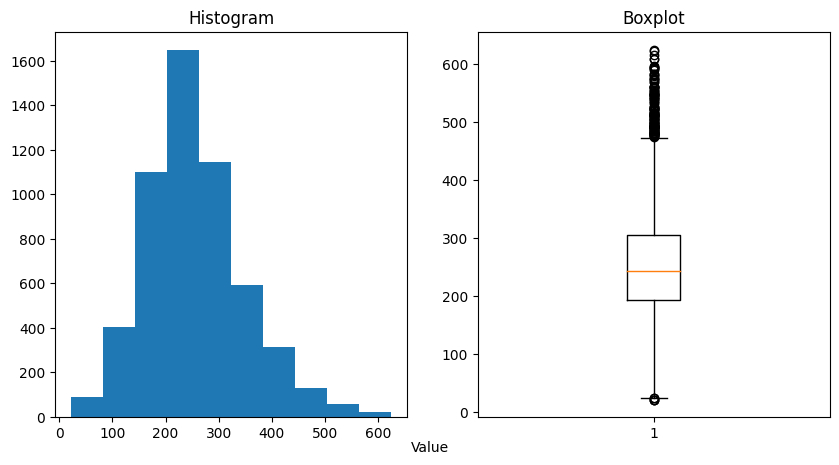

In [ ]:
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot the histogram on the first axis
ax1.hist(df['word_counts'], bins=10)
ax1.set_title('Histogram')

# plot the boxplot on the second axis
ax2.boxplot(df['word_counts'])
ax2.set_title('Boxplot')

# add a common x-axis label
fig.text(0.5, 0.04, 'Value', ha='center')

# show the plot
plt.show()


In [ ]:
df.to_csv('preprocessed_hcV3.csv', index = False)

In [ ]:
print(f"Number of True statements: {df[df['memType'] == 'recalled'].shape[0]}")
print(f"Number of False statements: {df[df['memType'] == 'imagined'].shape[0]}")

Number of True statements: 2770
Number of False statements: 2736


In [ ]:
# Reupdate the doc
docs = []

for doc in nlp.pipe(df['story'], n_process=os.cpu_count()-1, disable = ['transformer']):
    docs.append(doc)

# Linguistic Features Extraction:

## TEXTSTAT

TEXTSTAT is a Python package that provides a variety of text statistics, including readability scores and other metrics. Here's an example of how to use textstat to compute summary statistics for a text:

This code computes several summary statistics for the text variable:


1.   The number of sentences is computed using the sentence_count function from textstat.
2. The number of words is computed using the lexicon_count function.
3. The number of syllables is computed using the syllable_count function.
4. The average number of syllables per word is computed by dividing the total number of syllables by the total number of words.
5. The Flesch-Kincaid Grade Level is computed using the flesch_kincaid_grade function.
6. The Flesch Readability Ease is computed using the flesch_reading_ease function.





In [ ]:
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.8 MB/s eta 0:00:00


In [ ]:
import textstat

text_stats_df = pd.DataFrame()

for text in df['story']:
  # Compute the number of sentences
  num_sentences = textstat.sentence_count(text)
  # Compute the number of words
  num_words = textstat.lexicon_count(text)
  # Compute the number of syllables
  num_syllables = textstat.syllable_count(text)
  # Compute the average number of syllables per word
  avg_syllables_per_word = num_syllables / num_words
  # Compute the Flesch-Kincaid Grade Level (focus on sentence length)
  fk_grade = textstat.flesch_kincaid_grade(text)
  # Compute the Flesch Reading Ease Level (focus on syllables length)
  fk_read = textstat.flesch_reading_ease(text)

  # Create a dictionary with the computed values
  text_stats_dict = {
      'num_sentences': num_sentences,
      #'num_words': num_words,
      'num_syllables': num_syllables,
      'avg_syllables_per_word': avg_syllables_per_word,
      'fk_grade': fk_grade,
      'fk_read': fk_read
  }

  # Append the dictionary to text_stats_df as a new row
  # text_stats_df = text_stats_df.append(text_stats_dict, ignore_index=True)
  text_stats_df = pd.concat([text_stats_df, pd.DataFrame(text_stats_dict, index=[0])], ignore_index=True)


# Display the final dataset:
text_stats_df

,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read
0,15,271,1.334975,5.0,83.15
1,16,219,1.196721,3.0,93.74
2,21,337,1.266917,4.7,83.96
3,15,207,1.254545,4.0,85.69
4,15,195,1.203704,2.8,94.35
...,...,...,...,...,...
5501,25,363,1.238908,3.1,93.44
5502,15,389,1.341379,7.3,77.27
5503,16,208,1.283951,3.7,86.60
5504,17,437,1.300595,7.5,76.76


## LIWC - load output

Use this code if you already have a dataset output obtained by LIWC-22 https://www.liwc.app

In [ ]:
liwc_df = pd.read_csv('/content/LIWC-22_tokenizedtext_hcV3.csv', sep=',')
liwc_df

,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,1,204,29.85,37.25,78.94,95.42,204.0,18.14,94.12,82.35,...,0.0,0.0,0.49,0.0,0.0,0.0,0.0,0.49,0.00,0
1,1,187,59.56,43.20,78.46,98.35,187.0,10.70,90.37,78.07,...,0.0,0.0,1.60,0.0,0.0,0.0,0.0,1.60,0.00,0
2,1,269,45.02,31.73,83.20,48.55,269.0,10.41,95.54,75.84,...,0.0,0.0,0.37,0.0,0.0,0.0,0.0,0.37,0.00,0
3,1,167,1.00,61.41,48.87,57.69,167.0,10.78,95.21,81.44,...,0.0,0.0,1.20,0.0,0.0,0.0,0.0,1.20,0.00,0
4,1,165,36.20,1.92,97.64,67.94,165.0,8.48,92.73,78.18,...,0.0,0.0,1.82,0.0,0.0,0.0,0.0,1.82,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,1,297,9.31,10.30,83.87,10.27,297.0,13.47,92.26,81.48,...,0.0,0.0,1.35,0.0,0.0,0.0,0.0,1.35,0.00,0
5502,1,290,98.04,52.40,94.42,16.31,290.0,18.97,91.72,69.66,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0
5503,1,163,24.25,93.35,14.42,99.00,163.0,13.50,92.02,75.46,...,0.0,0.0,0.61,0.0,0.0,0.0,0.0,0.61,0.00,0
5504,1,344,8.25,45.22,6.76,56.53,344.0,11.92,95.06,80.23,...,0.0,0.0,2.62,0.0,0.0,0.0,0.0,2.03,0.58,0


In [ ]:
list(liwc_df.columns)

['Segment',
 'WC',
 'Analytic',
 'Clout',
 'Authentic',
 'Tone',
 'WPS',
 'BigWords',
 'Dic',
 'Linguistic',
 'function',
 'pronoun',
 'ppron',
 'i',
 'we',
 'you',
 'shehe',
 'they',
 'ipron',
 'det',
 'article',
 'number',
 'prep',
 'auxverb',
 'adverb',
 'conj',
 'negate',
 'verb',
 'adj',
 'quantity',
 'Drives',
 'affiliation',
 'achieve',
 'power',
 'Cognition',
 'allnone',
 'cogproc',
 'insight',
 'cause',
 'discrep',
 'tentat',
 'certitude',
 'differ',
 'memory',
 'Affect',
 'tone_pos',
 'tone_neg',
 'emotion',
 'emo_pos',
 'emo_neg',
 'emo_anx',
 'emo_anger',
 'emo_sad',
 'swear',
 'Social',
 'socbehav',
 'prosocial',
 'polite',
 'conflict',
 'moral',
 'comm',
 'socrefs',
 'family',
 'friend',
 'female',
 'male',
 'Culture',
 'politic',
 'ethnicity',
 'tech',
 'Lifestyle',
 'leisure',
 'home',
 'work',
 'money',
 'relig',
 'Physical',
 'health',
 'illness',
 'wellness',
 'mental',
 'substances',
 'sexual',
 'food',
 'death',
 'need',
 'want',
 'acquire',
 'lack',
 'fulfill',
 '

In [ ]:
# Select column of interest:
liwc_final = liwc_df[['Analytic',
                      'Authentic',
                      'Tone',
                        'tone_pos',
                        'tone_neg',
                      'focuspast',
                      'focuspresent',
                      'focusfuture',
                      'Cognition',       # Cognitive Operations
                        'memory']].copy()

# Distancing
liwc_final.loc[:, 'Self-reference'] = liwc_df['i'] + liwc_df['we']
liwc_final.loc[:, 'Other-reference'] = liwc_df['shehe'] + liwc_df['they'] + liwc_df['you']

# Contextual Embedding
liwc_final.loc[:, 'Contextual Embedding'] = liwc_df['space'] + liwc_df['motion'] + liwc_df['time']

# Perceptual Processes
liwc_final.loc[:, 'Perceptual Details'] = liwc_df['attention'] + liwc_df['visual'] + liwc_df['auditory'] + liwc_df['feeling']

# Reality Monitoring
liwc_final.loc[:, 'Reality Monitoring'] = liwc_final['Perceptual Details'] + liwc_final['Contextual Embedding'] + liwc_df['Affect'] - liwc_df['Cognition']

# Add word counts and memType
#liwc_final.loc[:, 'word_counts'] = liwc_df['WC']
#liwc_final.loc[:, 'memType'] = liwc_df['memType']

# Display df:
liwc_final


,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
0,29.85,78.94,95.42,6.37,0.49,8.82,1.47,0.98,11.76,0.49,11.27,4.41,12.74,2.45,10.29
1,59.56,78.46,98.35,7.49,0.53,11.23,0.00,0.00,3.21,0.00,9.09,1.60,17.11,7.48,29.40
2,45.02,83.20,48.55,2.23,0.37,10.78,3.72,1.12,7.06,0.74,9.66,1.86,13.39,3.72,12.65
3,1.00,48.87,57.69,3.59,1.20,14.37,2.40,1.80,13.77,1.20,10.18,7.78,9.59,0.00,0.61
4,36.20,97.64,67.94,3.64,0.61,6.67,3.03,1.21,13.94,0.00,13.94,1.21,15.15,3.64,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,9.31,83.87,10.27,2.02,3.03,12.12,0.00,0.34,10.77,0.67,11.11,6.73,16.50,3.70,14.48
5502,98.04,94.42,16.31,1.03,1.38,8.28,0.00,1.72,7.24,0.34,2.07,3.79,23.79,1.72,21.37
5503,24.25,14.42,99.00,8.59,0.00,13.50,1.84,0.00,4.91,0.61,7.36,7.98,14.11,2.45,20.24
5504,8.25,6.76,56.53,4.07,1.74,13.37,0.87,1.45,15.70,0.29,6.39,10.47,11.04,1.74,2.89


In [ ]:
liwc_final.describe()

,Analytic,Authentic,Tone,tone_pos,tone_neg,focuspast,focuspresent,focusfuture,Cognition,memory,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring
count,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000,5506.000000
mean,39.040612,71.662841,51.973478,3.697886,1.490143,9.673758,2.010325,1.231753,11.014319,0.237579,9.818305,3.602345,14.393589,2.223879,11.014352
std,22.024476,27.705596,31.124971,2.125503,1.319069,3.152343,1.742185,1.167257,3.711885,0.448741,3.020319,2.987587,3.855324,1.433712,6.259278
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.240000,0.000000,-18.490000
25%,21.035000,54.132500,24.305000,2.170000,0.480000,7.730000,0.732500,0.420000,8.480000,0.000000,7.920000,1.190000,11.740000,1.200000,6.950000
50%,36.090000,81.580000,52.560000,3.370000,1.200000,9.880000,1.550000,0.970000,10.810000,0.000000,9.860000,2.860000,14.205000,2.020000,11.075000
75%,54.537500,95.117500,80.407500,4.850000,2.200000,11.800000,2.820000,1.710000,13.370000,0.380000,11.850000,5.467500,16.827500,3.000000,15.267500
max,99.000000,99.000000,99.000000,18.180000,9.090000,22.730000,11.280000,10.090000,30.250000,10.080000,22.730000,24.000000,32.220000,11.240000,37.150000


## Named Entity Recognition

In [ ]:
# Load .csv files from the Notebook 'Memory_NER_Transformer' and concatenate all the datasets.

# Load:
ner_1 = pd.read_csv('ner_hippocorpus_1000.csv')
ner_2 = pd.read_csv('ner_hippocorpus_2000.csv')
ner_3 = pd.read_csv('ner_hippocorpus_3000.csv')
ner_4 = pd.read_csv('ner_hippocorpus_4000.csv')
ner_5 = pd.read_csv('ner_hippocorpus_5000.csv')

# Concatenate all the datasets:
ner_df = pd.concat([ner_1, ner_2, ner_3, ner_4, ner_5]).fillna(0)
ner_df = ner_df.reset_index(drop=True) # stop resetting the row index

# Display the merged dataset
ner_df

,DATE,TIME,GPE,LOC,PERSON,ORDINAL,ORG,QUANTITY,WORK_OF_ART,PRODUCT,CARDINAL,NORP,MONEY,LANGUAGE,FAC,EVENT,PERCENT,LAW,word_counts,memType
0,0.004902,0.004902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,204,imagined
1,0.010695,0.005348,0.005348,0.005348,0.005348,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,187,recalled
2,0.022305,0.000000,0.000000,0.000000,0.000000,0.011152,0.003717,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,269,imagined
3,0.011976,0.000000,0.000000,0.000000,0.000000,0.011976,0.000000,0.005988,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,167,recalled
4,0.018182,0.006061,0.012121,0.000000,0.000000,0.012121,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,165,imagined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,0.013468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,297,recalled
5502,0.003448,0.003448,0.003448,0.000000,0.000000,0.003448,0.000000,0.000000,0.0,0.0,0.013793,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,290,recalled
5503,0.006135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,163,recalled
5504,0.008746,0.002915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.002915,0.0,0.0,0.0,0.0,0.0,343,recalled


In [ ]:
print("Entity\t\tDESCRIPTION")
print("---------------------------")

for ent in list(ner_df.columns[:-2]):
  print(ent+"\t\t"+spacy.explain(ent))

Entity		DESCRIPTION
---------------------------
DATE		Absolute or relative dates or periods
TIME		Times smaller than a day
GPE		Countries, cities, states
LOC		Non-GPE locations, mountain ranges, bodies of water
PERSON		People, including fictional
ORDINAL		"first", "second", etc.
ORG		Companies, agencies, institutions, etc.
QUANTITY		Measurements, as of weight or distance
WORK_OF_ART		Titles of books, songs, etc.
PRODUCT		Objects, vehicles, foods, etc. (not services)
CARDINAL		Numerals that do not fall under another type
NORP		Nationalities or religious or political groups
MONEY		Monetary values, including unit
LANGUAGE		Any named language
FAC		Buildings, airports, highways, bridges, etc.
EVENT		Named hurricanes, battles, wars, sports events, etc.
PERCENT		Percentage, including "%"
LAW		Named documents made into laws.


Group the columns representing the same construct:

**Temporal Details**: Data + Time + Event

**Spatial Details**: GPE + Lol + Faculties

**People**: Person

**Quantity Details**: Percent + Money + Quantity + Cardinal + Ordinal

**Other Details (concrete reference to smth)**: Org + Norp + Language + Work_of_art + Product + Law



In [ ]:
new_ner = pd.DataFrame([])
new_ner['Temporal details'] = ner_df['DATE'] + ner_df['TIME'] + ner_df['EVENT']
new_ner['Spatial details'] = ner_df['GPE'] + ner_df['LOC'] + ner_df['FAC']
new_ner['People'] = ner_df['PERSON']
new_ner['Quantity details'] = ner_df['PERCENT'] + ner_df['MONEY'] + ner_df['QUANTITY'] + ner_df['CARDINAL'] + ner_df['ORDINAL']
# new_ner['Others'] = ner_df['ORG'] + ner_df['NORP'] + ner_df['LANGUAGE'] + ner_df['WORK_OF_ART'] + ner_df['PRODUCT'] + ner_df['LAW']

new_ner.head()

,Temporal details,Spatial details,People,Quantity details
0,0.009804,0.000000,0.000000,0.000000
1,0.016043,0.010695,0.005348,0.000000
2,0.022305,0.000000,0.000000,0.011152
3,0.011976,0.000000,0.000000,0.017964
4,0.024242,0.012121,0.000000,0.012121


In [ ]:
new_ner.isna().sum()

Temporal details    0
Spatial details     0
People              0
Quantity details    0
dtype: int64

In [ ]:
new_ner.describe()

,Temporal details,Spatial details,People,Quantity details
count,5506.000000,5506.000000,5506.000000,5506.000000
mean,0.015516,0.002262,0.001507,0.004593
std,0.010323,0.006378,0.004342,0.005395
min,0.000000,0.000000,0.000000,0.000000
25%,0.008197,0.000000,0.000000,0.000000
50%,0.013889,0.000000,0.000000,0.003670
75%,0.021094,0.000000,0.000000,0.006938
max,0.133333,0.144330,0.068493,0.055556


## Concreteness

In [ ]:
# Load Brysbaert dataset
concr_df = pd.read_excel('/content/Brysbaert concreteness scoring.xlsx')
concr_df.head()

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX
0,a,0,1.46,1.14,2,30,0.933333,1041179
1,aardvark,0,4.68,0.86,0,28,1.000000,21
2,aback,0,1.65,1.07,4,27,0.851852,15
3,abacus,0,4.52,1.12,2,29,0.931034,12
4,abandon,0,2.54,1.45,1,27,0.962963,413


In [ ]:
concr_df.shape

(39954, 8)

In [ ]:
def get_avg_concr_score(text):
    # Tokenize the story and convert to set
    tokens = set(text.split())

    # Get the concreteness score for each token
    matches = concr_df['Word'].str.lower().isin(tokens)
    scores = concr_df.loc[matches, 'Conc.M'].values

    # Compute the average score
    avg_score = scores.mean() if len(scores) > 0 else 0

    return avg_score

In [ ]:
df['concr_score'] = df.loc[:,'clean_text'].apply(get_avg_concr_score)

In [ ]:
df.head()

,AssignmentId,WorkTimeInSeconds,WorkerId,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,...,similarity,similarityReason,story,stressful,summary,timeSinceEvent,tokens,clean_text,word_counts,concr_score
0,32RIADZISTQWI5XIVG5BN0VMYFRS4U,1641,E9TY34YY,25.0,man,white,1.0,1.0,NaN,3.0,...,3.0,"I've been to a couple concerts, but not many.","Concerts are my most favorite thing, and my bo...",1.0,My boyfriend and I went to a concert together ...,90.0,concerts are my most favorite thing and my boy...,concert favorite thing boyfriend know annivers...,204,3.211373
1,3018Q3ZVOJCZJFDMPSFXATCQ4DARA2,1245,237K2NI1,25.0,woman,white,1.0,1.0,3.0,4.0,...,NaN,NaN,"The day started perfectly, with a great drive ...",1.0,My boyfriend and I went to a concert together ...,90.0,the day started perfectly with a great drive u...,day start perfectly great drive denver boyfrie...,187,3.600000
2,3IRIK4HM3B6UQBC0HI8Q5TBJZLEC61,1159,FK5QTANB,35.0,woman,black,1.0,1.0,NaN,4.0,...,3.0,I am a mother myself,It seems just like yesterday but today makes f...,1.0,My sister gave birth to my twin niece and neph...,150.0,it seems just like yesterday but today makes f...,like yesterday today make month ago happen wat...,269,3.170789
3,3018Q3ZVOJCZJFDMPSFXATCQG04RAI,500,UYOSBBRS,30.0,woman,white,1.0,4.0,3.0,5.0,...,NaN,NaN,"Five months ago, my niece and nephew were born...",2.0,My sister gave birth to my twin niece and neph...,150.0,five months ago my niece and nephew were born ...,month ago niece nephew bear sister child excit...,167,3.212000
4,3MTMREQS4W44RBU8OMP3XSK8NMJAWZ,1074,34BFLNJV,25.0,man,white,2.0,2.0,NaN,3.0,...,4.0,Because I also have money problems,About a month ago I went to burning man. I was...,4.0,It is always a journey for me to go to burning...,30.0,about a month ago i went to burning man i was ...,month ago go burn man have hard time life feel...,165,3.028000


## Jaccard Index

The Jaccard index is a measure of similarity between two sets. In the context of text analysis, we can use the Jaccard index to compare the vocabulary used in two texts. Here we compute the general Jaccard index between 'imagined' and 'recalled' stories.

We convert each group to a set of unique words using the split and explode methods of pandas. The split method splits each text into a list of words, and the explode method creates a new row for each word in the resulting list. This allows us to create a set of all the unique words in both columns.

We then compute the intersection and union of the two sets returning the Jaccard index which varies from 0 (completely different vocabulary among the two sets) and 1 (completly same vocabulary among the two sets).

In [ ]:
# Convert each column to sets of unique words
set1 = set(df_h['clean_text'].str.split().explode())
set2 = set(df_d['clean_text'].str.split().explode())

# Compute the intersection and union of the two sets
intersection = set1.intersection(set2)
union = set1.union(set2)

# Compute the Jaccard index
jaccard_index = len(intersection) / len(union)

print(f"Jaccard index: {jaccard_index:.2f}")


Jaccard index: 0.46


# Data Analysis

In [ ]:
# Merge the datasets containing the results
# al massimo word_counts diventa num_tokens
labels = pd.Series(df['memType']).reset_index().drop('index', axis = 1)
word_counts = pd.Series(df['word_counts']).reset_index().drop('index', axis = 1)
concr_score = df['concr_score'].reset_index().drop('index', axis = 1)

scoring_df = pd.concat([labels,word_counts,text_stats_df,liwc_final,concr_score,new_ner] , axis=1)
scoring_df

,memType,word_counts,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,Tone,...,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring,concr_score,Temporal details,Spatial details,People,Quantity details
0,imagined,204,15,271,1.334975,5.0,83.15,29.85,78.94,95.42,...,11.27,4.41,12.74,2.45,10.29,3.211373,0.009804,0.000000,0.000000,0.000000
1,recalled,187,16,219,1.196721,3.0,93.74,59.56,78.46,98.35,...,9.09,1.60,17.11,7.48,29.40,3.600000,0.016043,0.010695,0.005348,0.000000
2,imagined,269,21,337,1.266917,4.7,83.96,45.02,83.20,48.55,...,9.66,1.86,13.39,3.72,12.65,3.170789,0.022305,0.000000,0.000000,0.011152
3,recalled,167,15,207,1.254545,4.0,85.69,1.00,48.87,57.69,...,10.18,7.78,9.59,0.00,0.61,3.212000,0.011976,0.000000,0.000000,0.017964
4,imagined,165,15,195,1.203704,2.8,94.35,36.20,97.64,67.94,...,13.94,1.21,15.15,3.64,9.09,3.028000,0.024242,0.012121,0.000000,0.012121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,recalled,297,25,363,1.238908,3.1,93.44,9.31,83.87,10.27,...,11.11,6.73,16.50,3.70,14.48,3.115529,0.013468,0.000000,0.000000,0.000000
5502,recalled,290,15,389,1.341379,7.3,77.27,98.04,94.42,16.31,...,2.07,3.79,23.79,1.72,21.37,3.396707,0.006897,0.003448,0.000000,0.017241
5503,recalled,163,16,208,1.283951,3.7,86.60,24.25,14.42,99.00,...,7.36,7.98,14.11,2.45,20.24,3.471778,0.006135,0.000000,0.000000,0.000000
5504,recalled,343,17,437,1.300595,7.5,76.76,8.25,6.76,56.53,...,6.39,10.47,11.04,1.74,2.89,3.100556,0.011662,0.000000,0.000000,0.002915


In [ ]:
list(scoring_df.columns)

['memType',
 'word_counts',
 'num_sentences',
 'num_syllables',
 'avg_syllables_per_word',
 'fk_grade',
 'fk_read',
 'Analytic',
 'Authentic',
 'Tone',
 'tone_pos',
 'tone_neg',
 'focuspast',
 'focuspresent',
 'focusfuture',
 'Cognition',
 'memory',
 'Self-reference',
 'Other-reference',
 'Contextual Embedding',
 'Perceptual Details',
 'Reality Monitoring',
 'concr_score',
 'Temporal details',
 'Spatial details',
 'People',
 'Quantity details']

In [ ]:
scoring_df.to_csv('Memory_lingfeat.csv', index = False)

In [ ]:
# Load the downloaded dataset with scoring when you want just to perform the data analysis:
scoring_df = pd.read_csv('Memory_lingfeat.csv')
scoring_df.head()

,memType,word_counts,num_sentences,num_syllables,avg_syllables_per_word,fk_grade,fk_read,Analytic,Authentic,Tone,...,Self-reference,Other-reference,Contextual Embedding,Perceptual Details,Reality Monitoring,concr_score,Temporal details,Spatial details,People,Quantity details
0,imagined,204,15,271,1.334975,5.0,83.15,29.85,78.94,95.42,...,11.27,4.41,12.74,2.45,10.29,3.211373,0.009804,0.000000,0.000000,0.000000
1,recalled,187,16,219,1.196721,3.0,93.74,59.56,78.46,98.35,...,9.09,1.60,17.11,7.48,29.40,3.600000,0.016043,0.010695,0.005348,0.000000
2,imagined,269,21,337,1.266917,4.7,83.96,45.02,83.20,48.55,...,9.66,1.86,13.39,3.72,12.65,3.170789,0.022305,0.000000,0.000000,0.011152
3,recalled,167,15,207,1.254545,4.0,85.69,1.00,48.87,57.69,...,10.18,7.78,9.59,0.00,0.61,3.212000,0.011976,0.000000,0.000000,0.017964
4,imagined,165,15,195,1.203704,2.8,94.35,36.20,97.64,67.94,...,13.94,1.21,15.15,3.64,9.09,3.028000,0.024242,0.012121,0.000000,0.012121


In [ ]:
# splitting the dataset in two groups
scoring_df_h = scoring_df[scoring_df['memType']=='recalled'].reset_index().drop(['memType','index'], axis=1)
scoring_df_d = scoring_df[scoring_df['memType']=='imagined'].reset_index().drop(['memType','index'], axis=1)

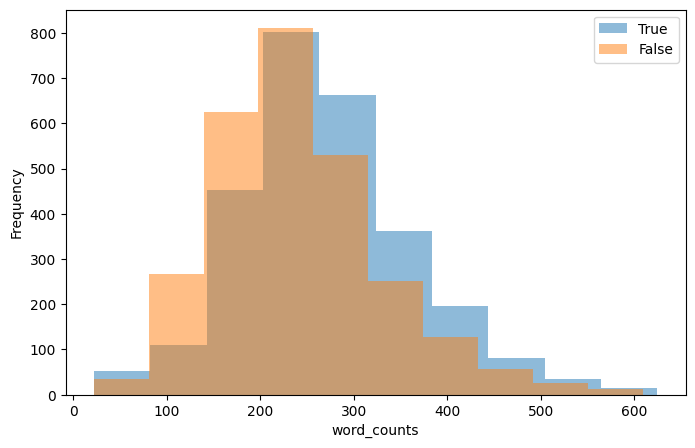

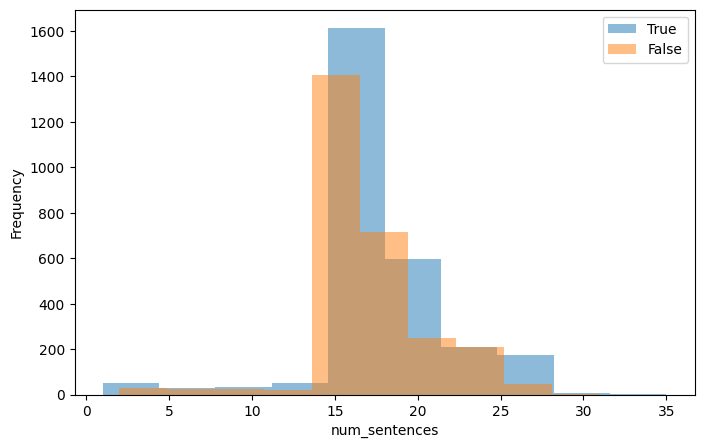

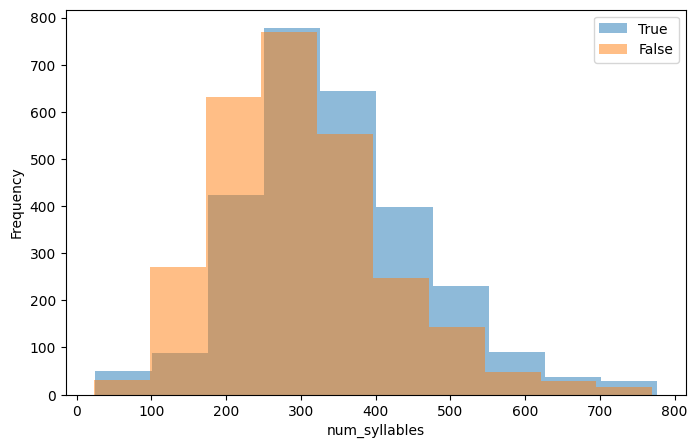

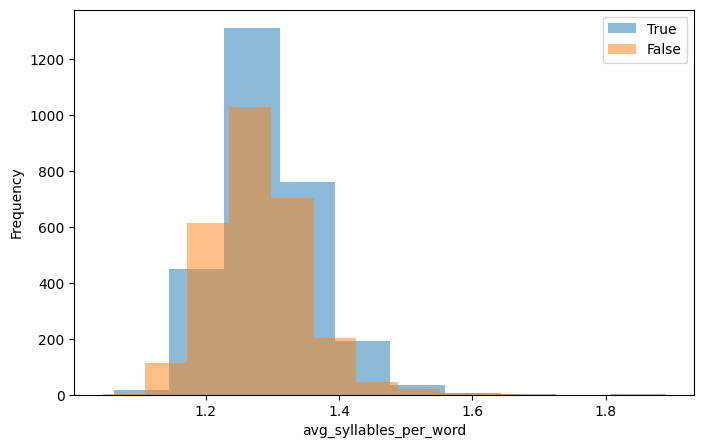

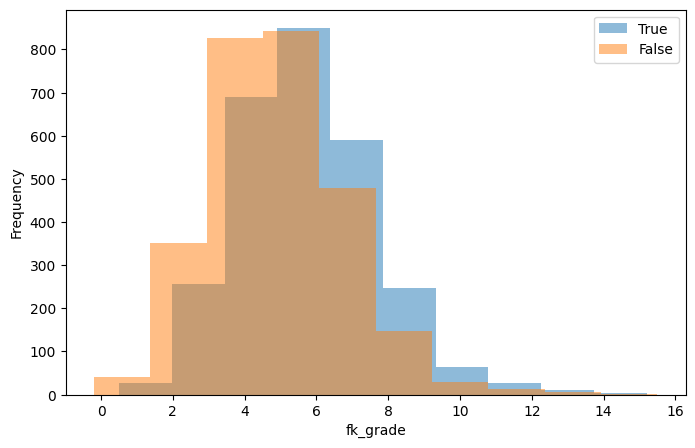

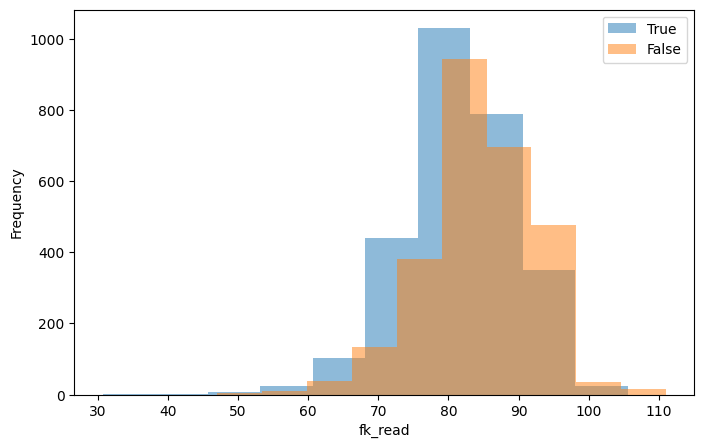

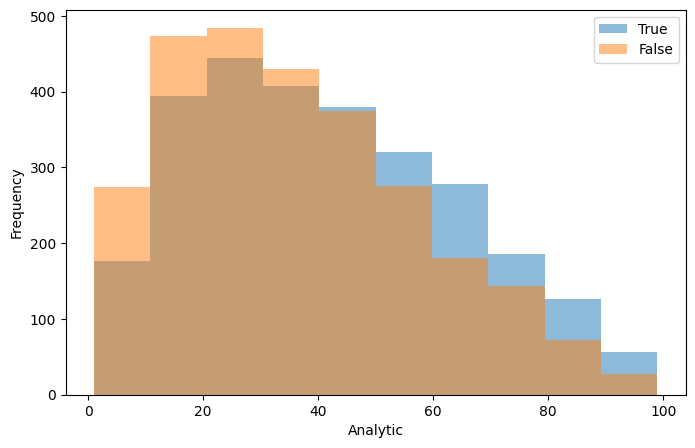

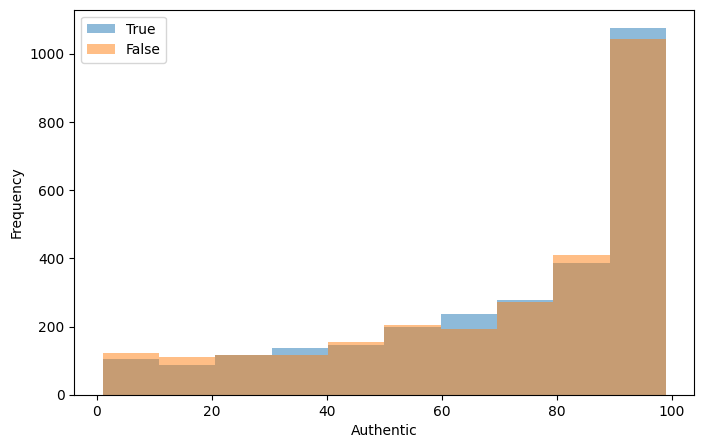

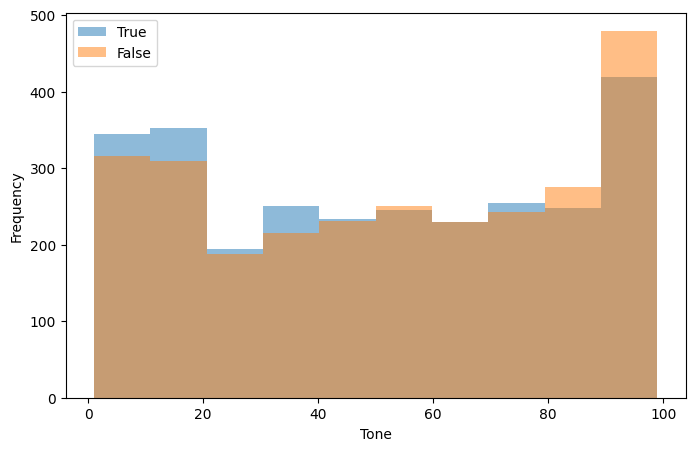

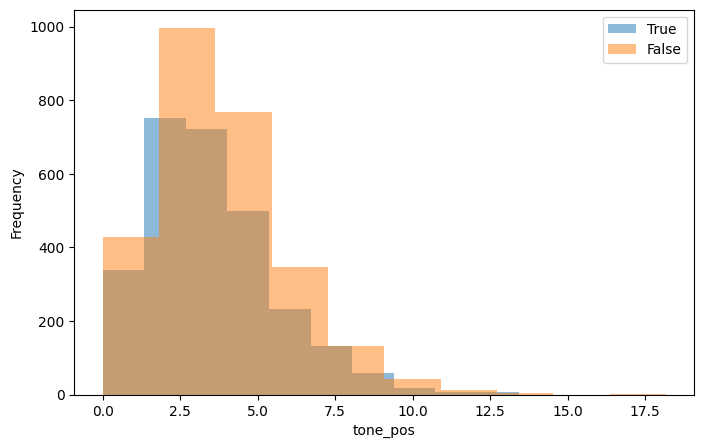

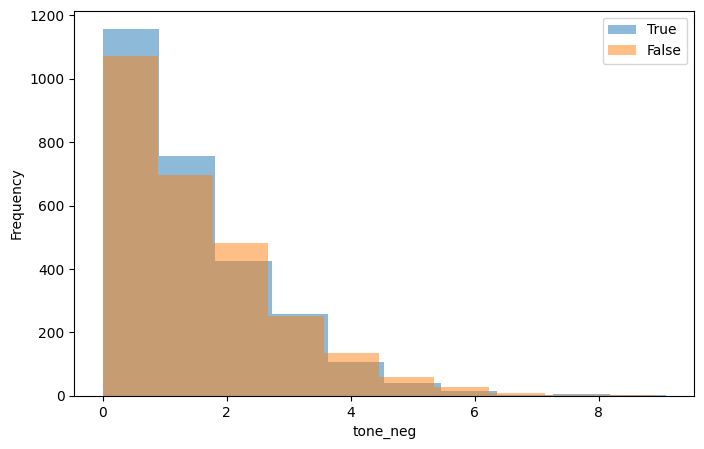

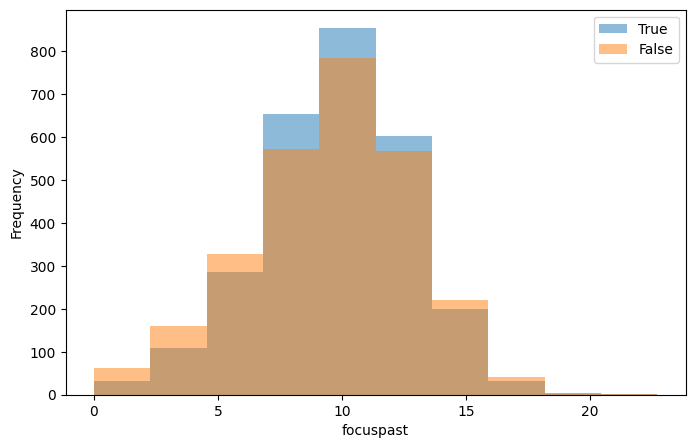

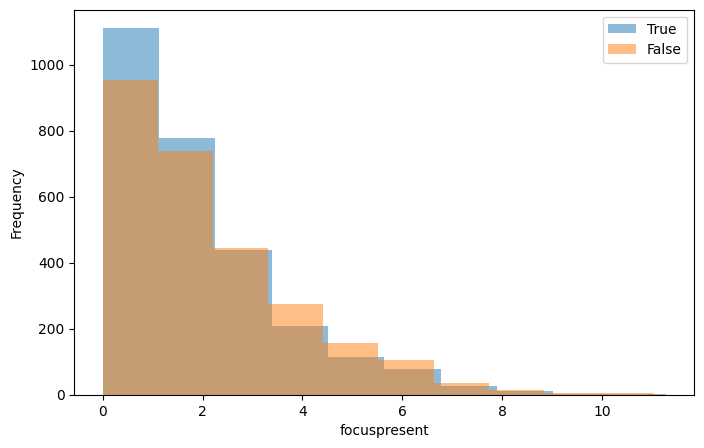

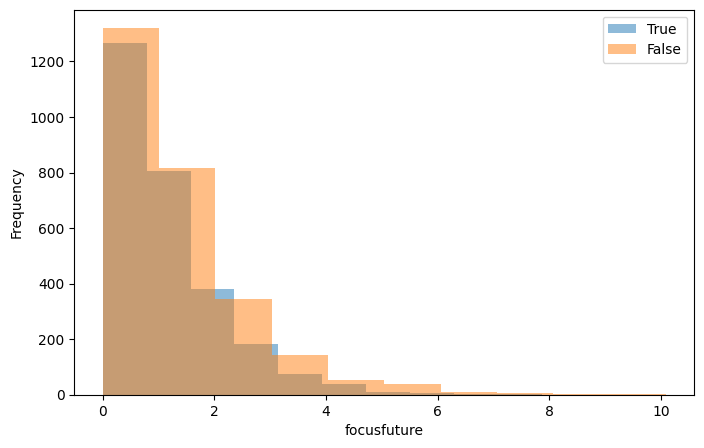

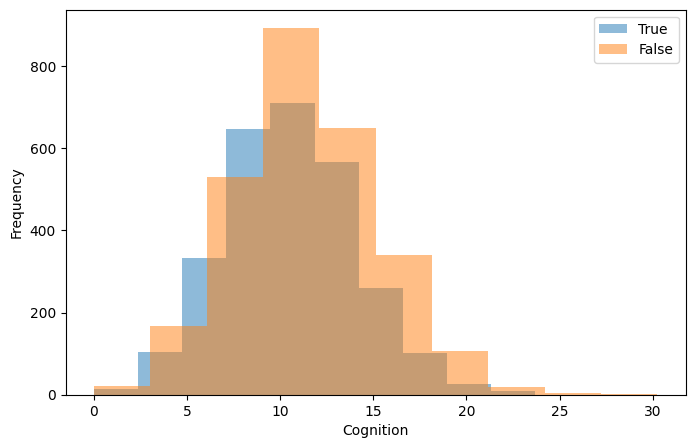

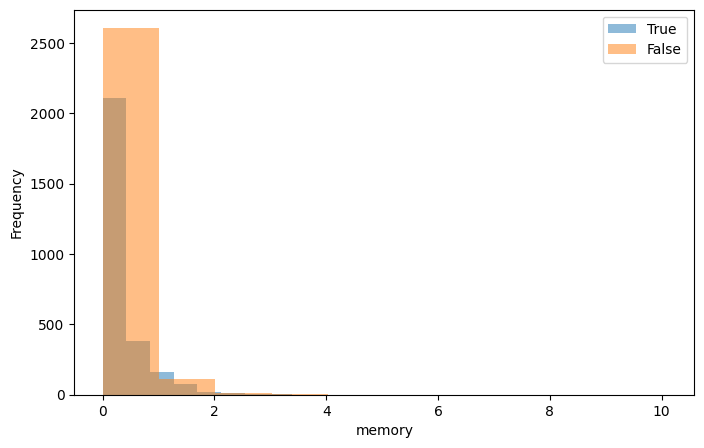

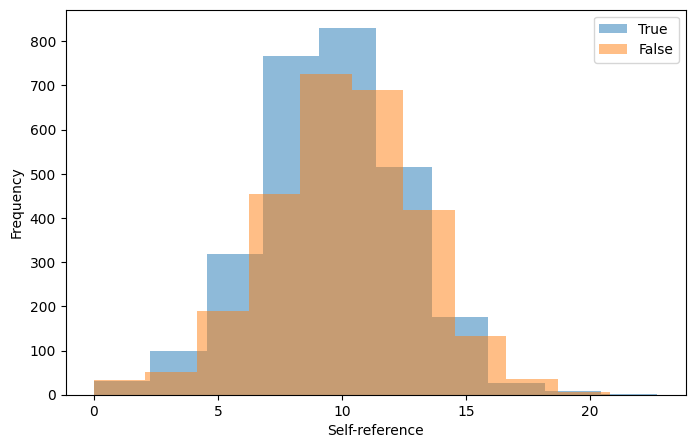

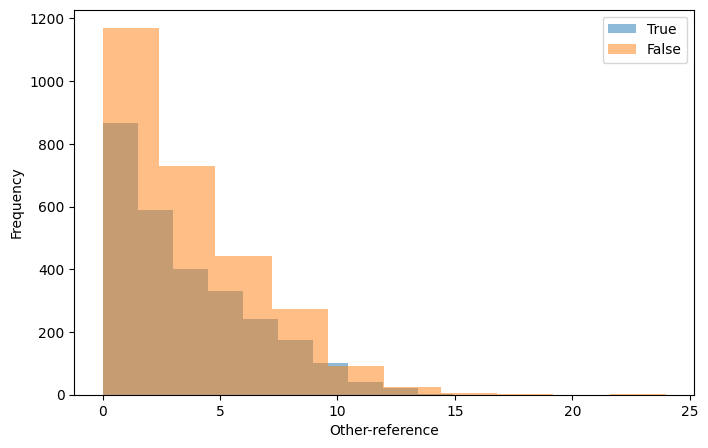

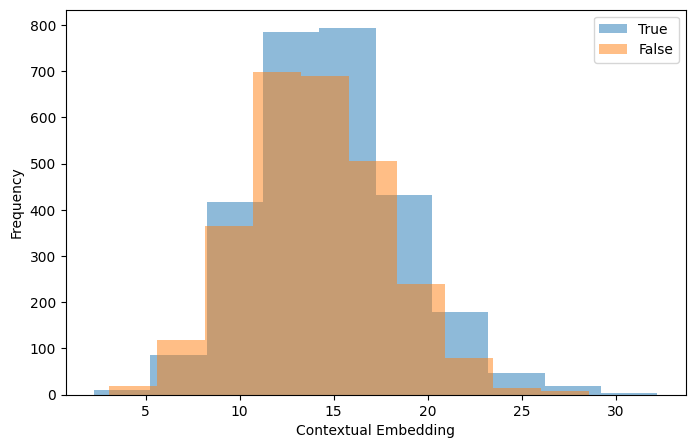

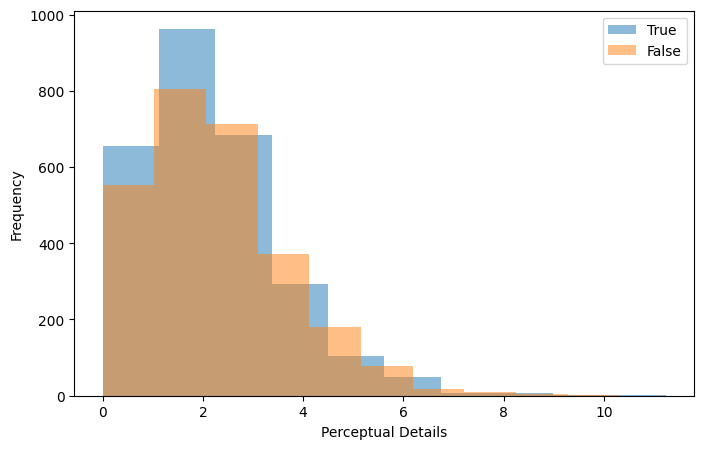

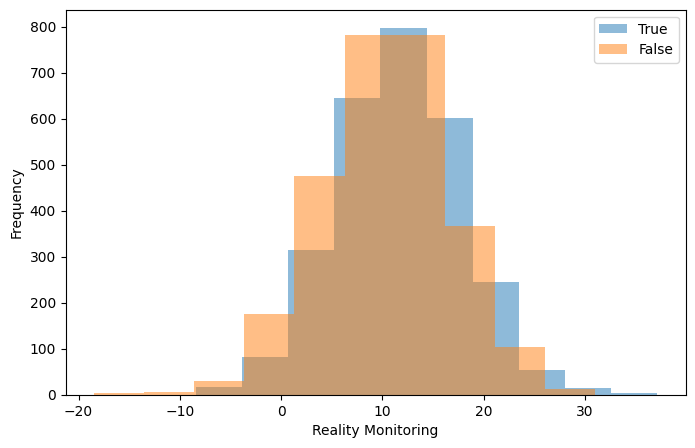

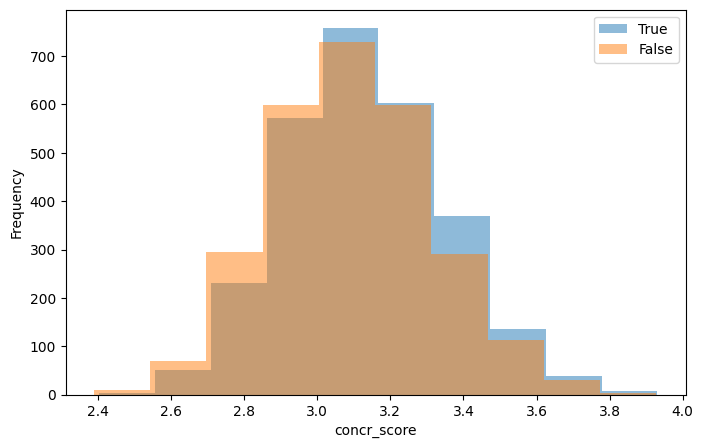

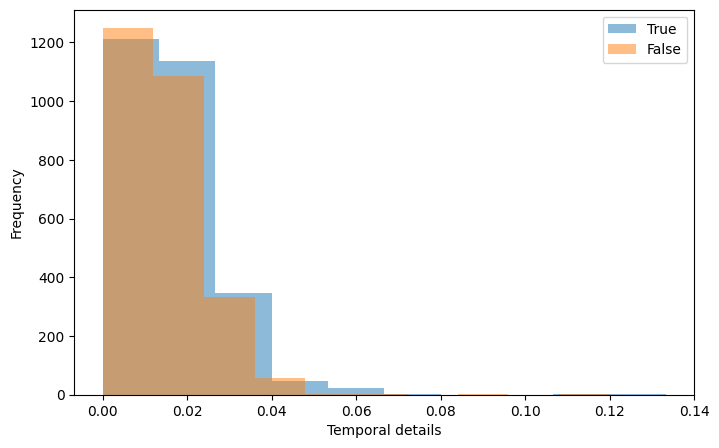

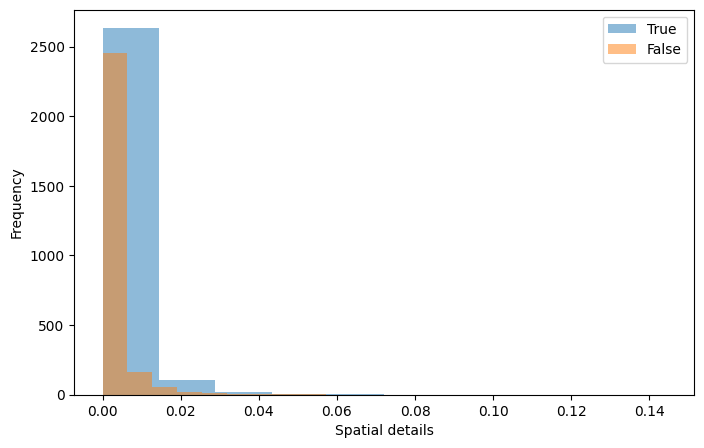

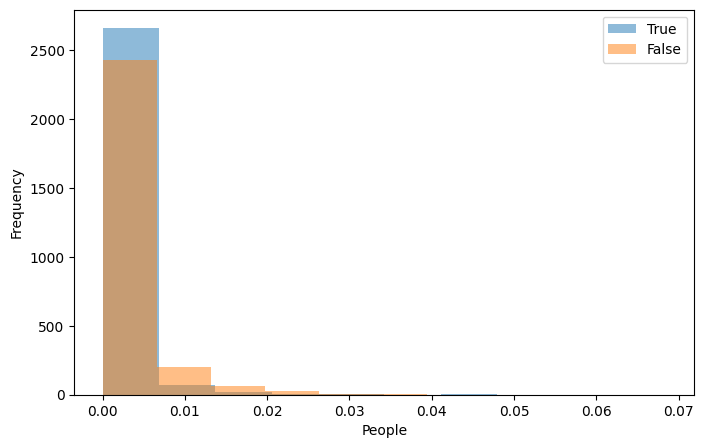

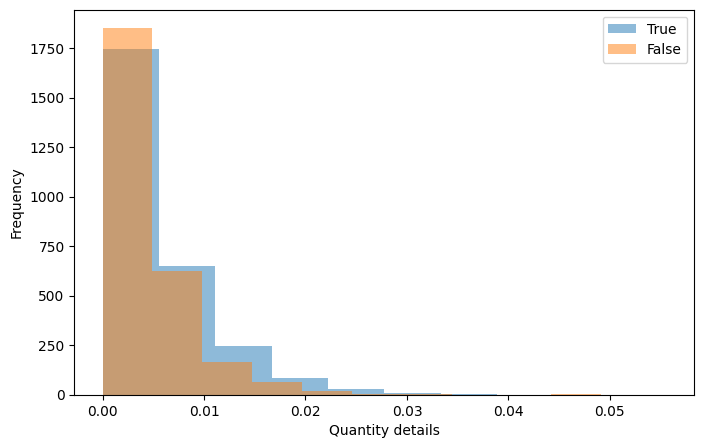

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms
for score in scoring_df_h:
    # Plot histogram for score in scoring_df_h
    scoring_df_h[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'True')

    # Plot histogram for score in scoring_df_d
    scoring_df_d[score].plot.hist(alpha=0.5, figsize=(8, 5), bins=10, label = 'False')

    # Add labels to variables
    plt.xlabel(score)
    plt.ylabel('Frequency')
    plt.legend()

    # Show plot
    plt.show()


Boxplot

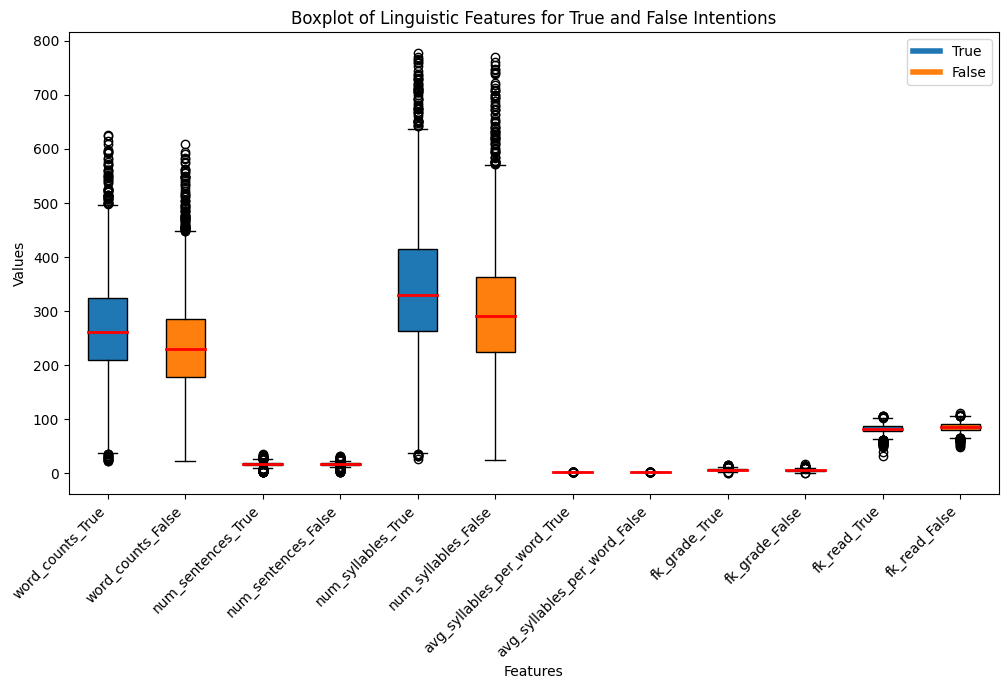

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,1:7].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


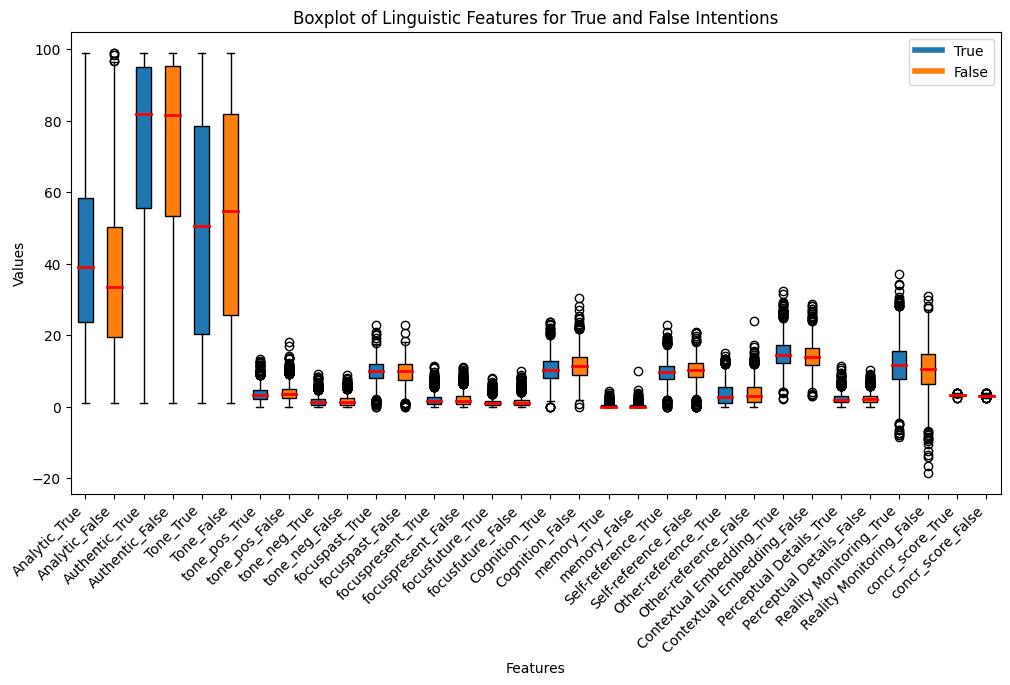

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,7:-4].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


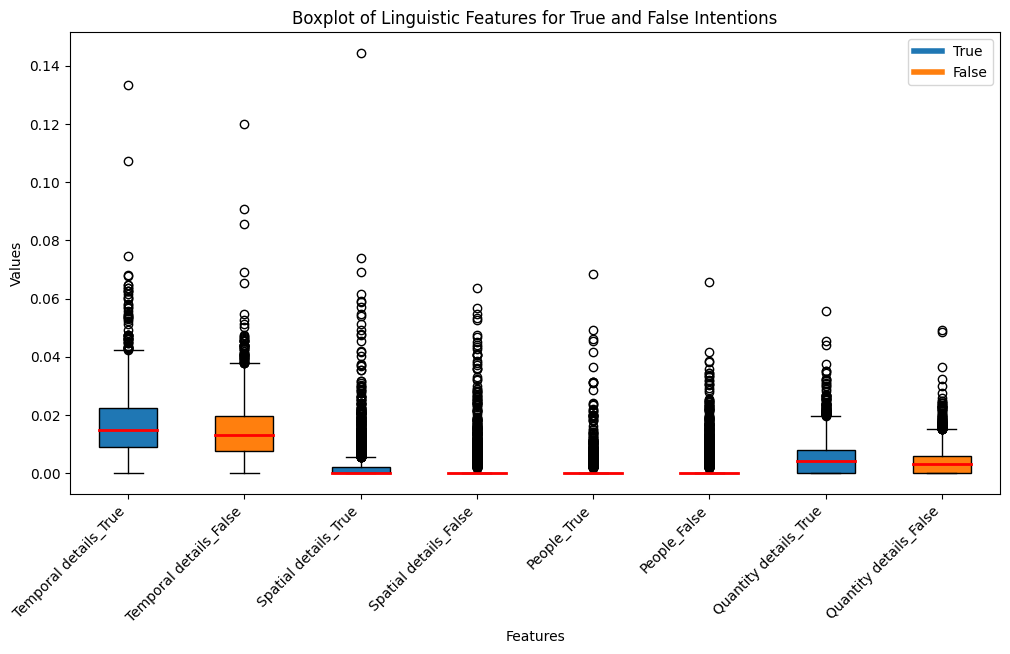

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

columns = scoring_df.iloc[:,-4:].columns

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create lists for boxplot data, labels, and colors
boxplot_data = []
boxplot_labels = []
colors = []

# Prepare the data for the boxplot
for column in columns:
    boxplot_data.extend([scoring_df_h[column], scoring_df_d[column]])
    boxplot_labels.extend([f"{column}_True", f"{column}_False"])
    colors.extend(['C0', 'C1'])

# Create the boxplot using Matplotlib
bp = ax.boxplot(boxplot_data, patch_artist=True)

# Set colors and labels
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change the color of median lines to red
for median in bp['medians']:
    median.set(color='red', linewidth=2)

ax.set_xticklabels(boxplot_labels, rotation=45, ha="right")
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Boxplot of Linguistic Features for True and False Intentions')

# Create a legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', lw=4, label='True'),
                   Line2D([0], [0], color='C1', lw=4, label='False')]
ax.legend(handles=legend_elements)

# Show the plot
plt.show()


In [ ]:
## Define functions for analysis:

# Computing independent permutation tests:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

# Bootstrap CI for CLES
def bootstrap_cles_ci(x, y, alpha=0.05, n_boot=1000):
    boot_cles = []
    for _ in range(n_boot):
        sample_x = np.random.choice(x, size=len(x), replace=True)
        sample_y = np.random.choice(y, size=len(y), replace=True)
        cles = pg.compute_effsize(sample_x, sample_y, eftype='CLES')
        boot_cles.append(cles)
    lower = np.percentile(boot_cles, 100 * (alpha / 2))
    upper = np.percentile(boot_cles, 100 * (1 - alpha / 2))
    return (round((lower), 2), round((upper), 2))

# Compute Cohen's d and its CI
def cohen_d_and_ci(x, y, confidence=0.95):
    d = pg.compute_effsize(x, y, paired=False, eftype='cohen')
    ci_low, ci_high = pg.compute_esci(stat=d, nx=len(x), ny=len(y), paired=False, eftype='cohen', confidence=confidence)
    return d, (ci_low, ci_high)

# Apply the analysis:

stats = []
p_values = []
cles_scores = []
cles_cis = []
cohens_d_scores = []
cohens_d_cis = []

for col in scoring_df_h.columns:
    # stats and p-value:
    res = permutation_test((scoring_df_h[col], scoring_df_d[col]), statistic, vectorized=True, n_resamples=10000)
    stats.append(res.statistic)
    p_values.append(res.pvalue)

    # CLES effect size and CI:
    cles = pg.compute_effsize(scoring_df_h[col], scoring_df_d[col], eftype='CLES')
    cles_scores.append(cles)
    cles_ci = bootstrap_cles_ci(scoring_df_h[col], scoring_df_d[col])
    cles_cis.append(cles_ci)

    # Cohen's d effect size and CI:
    cohens_d, cohens_d_ci = cohen_d_and_ci(scoring_df_h[col], scoring_df_d[col])
    cohens_d_scores.append(cohens_d)
    cohens_d_cis.append(cohens_d_ci)

# perform multiple comparisons correction using Bonferroni method
null_h_rej, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# save results in a dataframe
perm_df = pd.DataFrame({
    "feature": scoring_df_h.columns,
    "stat": stats,
    "p_value": p_values,
    "corrected_p_value": corrected_p_values,
    "effect_size_cles": cles_scores,
    "cles_95%_CI": cles_cis,
    "effect_size_cohens_d": cohens_d_scores,
    "cohens_d_95%_CI": cohens_d_cis,
    "null_h_rejected": null_h_rej
})
perm_df["significance"] = ['*' if null_h else '-' for null_h in perm_df['null_h_rejected']]

# print all comparisons
perm_df.sort_values(["null_h_rejected", "effect_size_cles"], ascending=False, inplace=True)
perm_df


,feature,stat,p_value,corrected_p_value,effect_size_cles,cles_95%_CI,effect_size_cohens_d,cohens_d_95%_CI,null_h_rejected,significance
4,fk_grade,0.863012,0.000200,0.005199,0.629519,"(0.62, 0.64)",0.457238,"(0.4, 0.51)",True,*
2,num_syllables,41.276683,0.000200,0.005199,0.609806,"(0.6, 0.62)",0.352006,"(0.3, 0.41)",True,*
0,word_counts,29.268083,0.000200,0.005199,0.600748,"(0.59, 0.62)",0.320925,"(0.27, 0.37)",True,*
25,Quantity details,0.001524,0.000200,0.005199,0.578336,"(0.56, 0.59)",0.285242,"(0.23, 0.34)",True,*
6,Analytic,5.139291,0.000200,0.005199,0.565599,"(0.55, 0.58)",0.234928,"(0.18, 0.29)",True,*
3,avg_syllables_per_word,0.015160,0.000200,0.005199,0.558022,"(0.54, 0.57)",0.213269,"(0.16, 0.27)",True,*
22,Temporal details,0.002067,0.000200,0.005199,0.556380,"(0.54, 0.57)",0.201229,"(0.15, 0.25)",True,*
20,Reality Monitoring,1.216825,0.000200,0.005199,0.551393,"(0.54, 0.57)",0.195311,"(0.14, 0.25)",True,*
18,Contextual Embedding,0.728563,0.000200,0.005199,0.550192,"(0.53, 0.57)",0.189808,"(0.14, 0.24)",True,*
21,concr_score,0.036657,0.000200,0.005199,0.544066,"(0.53, 0.56)",0.165827,"(0.11, 0.22)",True,*


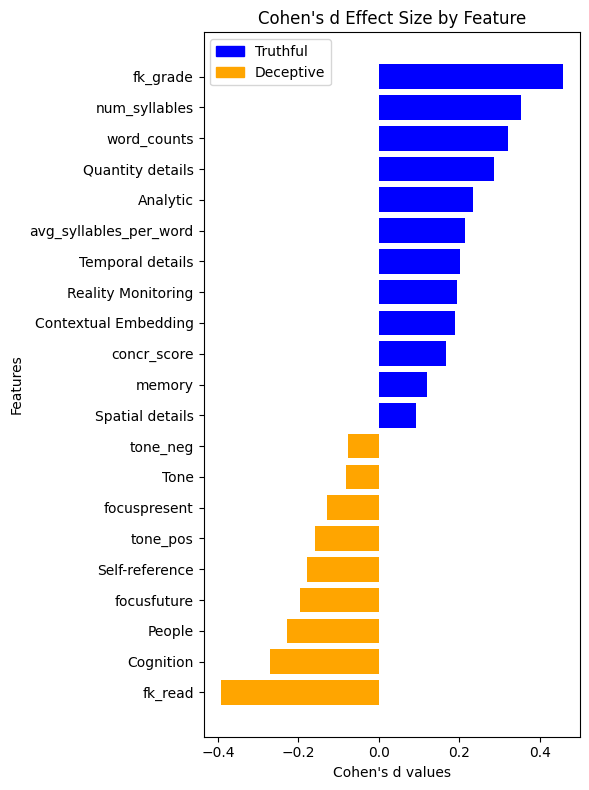

In [ ]:
import matplotlib.pyplot as plt

# Select only significant features
perm_df_selected = perm_df.loc[perm_df['null_h_rejected'] == True, :]

# Sort the dataframe by effect size in descending order
perm_df_sorted = perm_df_selected.sort_values("effect_size_cohens_d", ascending=True)

# Create a horizontal bar chart of effect size with an increased figure size
fig, ax = plt.subplots(figsize=(6, 8))  # Adjust the size (width, height) as needed

# Define colors based on the stat value
colors = ['blue' if stat > 0 else 'orange' for stat in perm_df_sorted['stat']]

# Plot the bars
bars = ax.barh(perm_df_sorted['feature'], perm_df_sorted['effect_size_cohens_d'], color=colors)

# Add legend
t_patch = plt.Rectangle((0, 0), 0, 0, color='blue', label='Truthful')
f_patch = plt.Rectangle((0, 0), 0, 0, color='orange', label='Deceptive')
plt.legend(handles=[t_patch, f_patch])

# Set labels
ax.set_xlabel("Cohen's d values")
ax.set_ylabel('Features')
ax.set_title("Cohen's d Effect Size by Feature")

# Show the plot
plt.tight_layout()
plt.show()

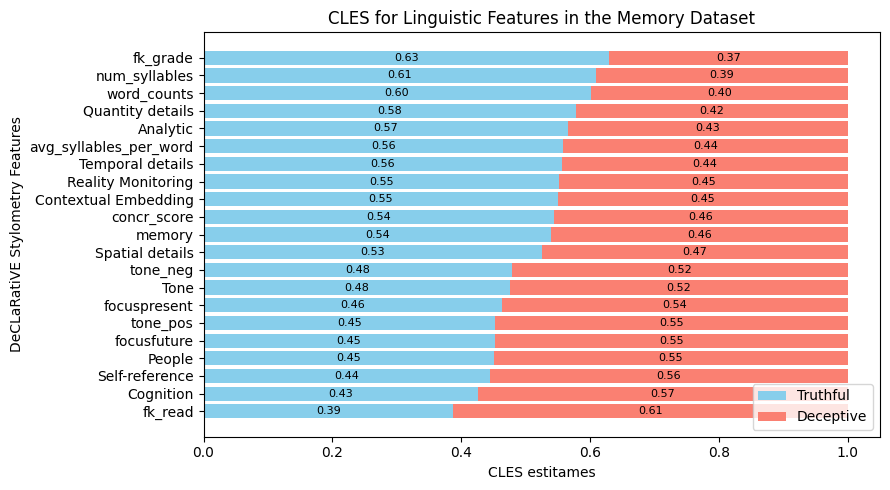

In [ ]:
import matplotlib.pyplot as plt

# Select only significant features
perm_df_selected = perm_df.loc[perm_df['null_h_rejected'] == True, :]

# Sort the dataframe by effect size in ascending order
perm_df_sorted = perm_df_selected.sort_values("effect_size_cles", ascending=True)

# Set the figure size
fig, ax = plt.subplots(figsize=(9, 5))

# Calculate 1 - cles for the deceptive part
perm_df_sorted['one_minus_cles'] = 1 - perm_df_sorted['effect_size_cles']

# Plotting the 'cles' part (Truthful) in blue
ax.barh(perm_df_sorted['feature'], perm_df_sorted['effect_size_cles'], color='skyblue', label='Truthful')

# Plotting the '1 - cles' part (Deceptive) in orange
ax.barh(perm_df_sorted['feature'], perm_df_sorted['one_minus_cles'], left=perm_df_sorted['effect_size_cles'], color='salmon', label='Deceptive')

# Add legend
plt.legend(loc='lower right')

# Set labels and title
ax.set_xlabel('CLES estitames')
ax.set_ylabel('DeCLaRatiVE Stylometry Features')
ax.set_title('CLES for Linguistic Features in the Memory Dataset')

# Adding the text labels on bars
for index, (cles, one_minus_cles) in enumerate(zip(perm_df_sorted['effect_size_cles'], perm_df_sorted['one_minus_cles'])):
    # Annotate the blue part (cles)
    ax.text(cles/2, index, f"{cles:.2f}", va='center', ha='center', color='black', fontsize=8)
    # Annotate the orange part (1 - cles)
    ax.text(cles + one_minus_cles/2, index, f"{one_minus_cles:.2f}", va='center', ha='center', color='black', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()